In [1]:
import os
import pandas as pd
import numpy as np
import dask.dataframe as dd
from numpy import dot
from numpy.linalg import norm
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.stats as ss
import json
import pathlib
from pycytominer import aggregate, normalize

%matplotlib inline  

In [2]:
# Set data input folder
# Download files described in README.md to this folder
input_folder = "inputs"

# Set output folder, subfolder
output_folder = "outputs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder, exist_ok=True)
if not os.path.exists(os.path.join(output_folder,"figure_panels")):
    os.makedirs(os.path.join(output_folder,"figure_panels"), exist_ok=True)

In [3]:
# Load barcodes used in experiment
guide_df = pd.read_csv("SABER_Library_ngt_Included_Oligo_Sequences_Assiged.csv")
all_guides_list = list(guide_df.iloc[:,4].unique())

count_df = pd.read_csv(os.path.join(output_folder,'HeLa_SABER_screen_SABER_arm_1_2_cell_count.csv.gz'))
count_df = count_df.rename(columns={'Metadata_Foci_Barcode_MatchedTo_GeneCode':'gene','Metadata_Foci_Barcode_MatchedTo_Barcode':'barcode'})
count_df['n_guides'] = np.nan

count_df

,gene,barcode,Cell_Count,n_guides
0,MFN2,AAATAAGAGACACATGGCTG,9849,NaN
1,AP3S1,CTTGCAGAAATGGTGATGGG,7927,NaN
2,NDUFAF7,GACACCTTTCATATACACTG,7261,NaN
3,SLC27A2,ATTCACGGATGTATTGTGGC,6622,NaN
4,DENND4B,TGCCAAGGGTGTTGTATGAG,6369,NaN
...,...,...,...,...
2395,RPS4X,TGTACATCGTATTACACCTG,59,NaN
2396,PAFAH1B1,TGGCTACTGAAGAAACATTG,58,NaN
2397,RPS24,TGACCAACCGACTACTTCAG,54,NaN
2398,GSR,TGGGCGGGTCCCGAATACCA,49,NaN


In [4]:
count_df_1000 = count_df.query('Cell_Count > 1000')
all_guides_list_1000 = list(count_df_1000.barcode.unique())
for guide in all_guides_list_1000:
    gene = list(count_df_1000.loc[count_df_1000['barcode']== guide,'gene'])[0]
    df_temp = count_df_1000.query('gene == @gene')
    count_df_1000.loc[count_df_1000['barcode']== guide,'n_guides'] = len(df_temp)
    
count_df_1000_4_guides = count_df_1000.query('n_guides >= 4')
selected_genes_list = list(count_df_1000_4_guides.gene.unique())
selected_guides_list = list(count_df_1000_4_guides.barcode.unique())
count_df_1000_4_guides

,gene,barcode,Cell_Count,n_guides
2,NDUFAF7,GACACCTTTCATATACACTG,7261,4.0
3,SLC27A2,ATTCACGGATGTATTGTGGC,6622,4.0
4,DENND4B,TGCCAAGGGTGTTGTATGAG,6369,4.0
5,MNT,CGTCCAATCTGAGCGTGCTG,6332,4.0
6,SMR3A,CTGGACCATAGGGTGGAGAA,6152,4.0
...,...,...,...,...
1575,HMCES,CTGTCGTAGTGATACCGTAA,1015,4.0
1576,SEC11C,CGGGAAGACCCAATCAGAGC,1013,4.0
1578,nontargeting,AGGGATCGTTAGGAAGGGAA,1012,35.0
1592,MRPL2,TTGTTGATGAGGGTCCCCAC,1002,4.0


In [5]:
cp498_guide_profiles_df = pd.read_csv('20240202_6W_CP498_SABER_Pilot_HeLa_SABER_only_guide_normalized_merged_feature_select_median_ALLWELLS_1_2.csv.gz')
selected_features = list(cp498_guide_profiles_df.columns)
len(selected_features)

3013

In [7]:
# Load and subset the single-cell profiles per plate for HeLa plates
plates = ['SABER_Plate_1','SABER_Plate_2']
chunksize = 10 ** 5

df_plate_list = []
for plate in plates:
    filename = f'20240202_6W_CP498_SABER_Pilot_HeLa_SABER_only_single_cell_normalized_ALLBATCHES___{plate}___ALLWELLS.csv.gz' 
    chunks = []
    with pd.read_csv(filename ,usecols=selected_features ,chunksize=chunksize) as reader:
        for chunk in reader:
            sub_chunk = chunk[chunk['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(selected_genes_list)]
            chunks.append(sub_chunk)
            print(chunk.shape,f'of plate {plate}')
            print(sub_chunk.shape,f'of plate {plate}')
    df = pd.concat(chunks)
    #df.to_csv(os.path.join(output_folder,f'20240202_6W_CP498_SABER_Pilot_HeLa_single_cell_profiles_ALLBATCHES___{plate}_ALLWELLS.csv.gz'),index = False)
    df_plate_list.append(df)

single_cell_df = pd.concat(df_plate_list)
single_cell_df

(100000, 3013) of plate SABER_Plate_1
(51960, 3013) of plate SABER_Plate_1
(100000, 3013) of plate SABER_Plate_1
(52251, 3013) of plate SABER_Plate_1
(100000, 3013) of plate SABER_Plate_1
(51920, 3013) of plate SABER_Plate_1
(100000, 3013) of plate SABER_Plate_1
(51330, 3013) of plate SABER_Plate_1
(100000, 3013) of plate SABER_Plate_1
(52130, 3013) of plate SABER_Plate_1
(100000, 3013) of plate SABER_Plate_1
(51356, 3013) of plate SABER_Plate_1
(100000, 3013) of plate SABER_Plate_1
(52046, 3013) of plate SABER_Plate_1
(100000, 3013) of plate SABER_Plate_1
(51872, 3013) of plate SABER_Plate_1
(100000, 3013) of plate SABER_Plate_1
(52313, 3013) of plate SABER_Plate_1
(100000, 3013) of plate SABER_Plate_1
(51983, 3013) of plate SABER_Plate_1
(100000, 3013) of plate SABER_Plate_1
(51921, 3013) of plate SABER_Plate_1
(100000, 3013) of plate SABER_Plate_1
(52315, 3013) of plate SABER_Plate_1
(100000, 3013) of plate SABER_Plate_1
(52057, 3013) of plate SABER_Plate_1
(100000, 3013) of plate S

,Metadata_Foci_Barcode_MatchedTo_GeneCode,Metadata_Foci_Barcode_MatchedTo_Barcode,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_BoundingBoxMaximum_Y,Cells_AreaShape_CentralMoment_0_1,Cells_AreaShape_CentralMoment_0_3,Cells_AreaShape_CentralMoment_1_0,Cells_AreaShape_CentralMoment_1_1,Cells_AreaShape_CentralMoment_1_2,Cells_AreaShape_CentralMoment_1_3,...,Nuclei_Texture_SumEntropy_Syto9_10_03_256,Nuclei_Texture_SumEntropy_btubulin_10_01_256,Nuclei_Texture_SumVariance_Calnexin_10_01_256,Nuclei_Texture_SumVariance_NfKb_10_01_256,Nuclei_Texture_SumVariance_Syto9_10_00_256,Nuclei_Texture_SumVariance_Syto9_10_02_256,Nuclei_Texture_SumVariance_TDP43_10_01_256,Nuclei_Texture_SumVariance_TDP43_10_02_256,Nuclei_Texture_SumVariance_TDP43_10_03_256,Nuclei_Texture_Variance_Syto9_10_01_256
3,SPIDR,AAGATCCGGACAGTGTCCTG,1.527000,-1.7305,-0.000074,0.000921,0.000256,-0.003292,-0.001700,0.000313,...,-5.152400,-4.230300,-1.07790,-0.806600,-0.596080,-0.597240,-1.555600,-1.536000,-1.56020,-0.581550
9,RABL3,TTAGTCCCTATTACCAACAG,1.586900,-1.7198,0.126150,0.015374,-0.027883,0.006718,-0.049640,0.003100,...,-1.482800,0.793230,0.27186,0.566770,-0.397910,-0.372000,0.568440,-0.468550,-1.27320,-0.253970
11,SH3BP4,TGAGTCTGACCACCAGGCCC,-0.001588,-1.7140,0.015406,-0.002093,-0.099845,-0.072192,-0.027788,-0.014131,...,0.227320,1.235400,-0.42138,-0.363900,-0.242530,-0.340410,0.348680,0.617990,-0.10826,-0.277760
16,PEF1,AGACCAATTGCAGTTGACCA,0.444440,-1.7116,0.008857,-0.000402,-0.089433,0.024325,-0.026541,0.004469,...,-0.563220,-0.119940,-0.65999,0.433820,-0.458590,-0.290700,-0.791770,0.020113,0.77679,-0.226710
19,SEC11C,GTCCGGCTTGGATATCTTCG,-0.494130,-1.7008,-0.078664,-0.064556,-0.640770,0.086314,-0.265800,0.014169,...,0.538070,0.458820,0.38762,-0.070644,-0.183000,-0.186880,-0.107080,-0.045529,0.35004,-0.141770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1886643,COX8A,GCTTGACAGGCTCGGCCCGG,-0.903370,1.7265,0.212770,-0.032457,0.078700,-0.046640,0.142550,-0.009611,...,-0.781290,-0.074671,-0.54062,-0.077842,-0.038009,-0.175730,1.239900,0.839830,0.64692,-0.181590
1886646,TOMM5,GACACTCACTGACTCGCAGG,1.366600,1.7265,0.197080,0.085124,0.575670,0.172540,0.083471,0.029052,...,-0.289250,-0.565110,-0.47086,0.107630,-0.085317,-0.008169,2.293400,0.471750,-0.27162,0.076941
1886647,TOMM5,GACACTCACTGACTCGCAGG,1.342200,1.7265,0.630120,0.025877,-0.195500,-0.469150,0.012387,-0.128550,...,0.397830,-0.315520,-0.65058,-0.292190,0.049942,-0.195420,-0.086787,-0.298550,-0.34852,-0.114370
1886649,NDUFA10,ACAGTTGCCATTATAGTCGG,0.291330,1.7265,1.822900,-0.162250,-0.458330,-0.522110,0.093939,-0.158070,...,-0.088139,0.430910,-0.21595,-0.081377,0.080167,0.115780,0.409930,0.082524,0.12418,-0.253790


In [8]:
subsample_ns = [100,200,300,400,500,750,1000]
subsample_dfs_dictionary = {} 
for n in subsample_ns:
    df_list_n = []
    for guide in selected_guides_list:
        df_temp = single_cell_df.query('Metadata_Foci_Barcode_MatchedTo_Barcode == @guide')
        if len(df_temp)<n:
            continue
        df_temp_sample = df_temp.sample(n=n,random_state=42)
        df_list_n.append(df_temp_sample)
    df_n = pd.concat(df_list_n)
    aggregate_df_n = aggregate(
        population_df=df_n,
        strata=['Metadata_Foci_Barcode_MatchedTo_GeneCode','Metadata_Foci_Barcode_MatchedTo_Barcode'],
        features='infer',
        operation='median'
    )
    subsample_dfs_dictionary[n]=aggregate_df_n
    aggregate_df_n.to_csv(f'CP498_SABER_arm_1_2_subsampled_aggregated_{n}_cells.csv',index=False)
    print(f'profiles at {n} representation level are aggregated.')
subsample_dfs_dictionary[subsample_ns[0]]

profiles at 100 representation level are aggregated.
profiles at 200 representation level are aggregated.
profiles at 300 representation level are aggregated.
profiles at 400 representation level are aggregated.
profiles at 500 representation level are aggregated.
profiles at 750 representation level are aggregated.
profiles at 1000 representation level are aggregated.


,Metadata_Foci_Barcode_MatchedTo_GeneCode,Metadata_Foci_Barcode_MatchedTo_Barcode,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_BoundingBoxMaximum_Y,Cells_AreaShape_CentralMoment_0_1,Cells_AreaShape_CentralMoment_0_3,Cells_AreaShape_CentralMoment_1_0,Cells_AreaShape_CentralMoment_1_1,Cells_AreaShape_CentralMoment_1_2,Cells_AreaShape_CentralMoment_1_3,...,Nuclei_Texture_SumEntropy_Syto9_10_03_256,Nuclei_Texture_SumEntropy_btubulin_10_01_256,Nuclei_Texture_SumVariance_Calnexin_10_01_256,Nuclei_Texture_SumVariance_NfKb_10_01_256,Nuclei_Texture_SumVariance_Syto9_10_00_256,Nuclei_Texture_SumVariance_Syto9_10_02_256,Nuclei_Texture_SumVariance_TDP43_10_01_256,Nuclei_Texture_SumVariance_TDP43_10_02_256,Nuclei_Texture_SumVariance_TDP43_10_03_256,Nuclei_Texture_Variance_Syto9_10_01_256
0,AARS2,AAAGGCGGCCCTCACGGCCG,0.295640,0.288730,0.025555,-0.001327,-0.040926,0.008993,0.006451,0.001574,...,-0.087294,-0.130275,-0.208150,-0.204435,-0.217120,-0.231720,0.051930,-0.077900,-0.128540,-0.206180
1,AARS2,AGCAAACTGGGGTCGCCGCG,0.404615,0.177765,-0.038774,-0.001844,-0.018796,-0.004643,0.000458,-0.000193,...,-0.043887,0.014302,-0.307495,-0.251535,-0.202370,-0.206690,-0.215680,-0.250165,-0.263890,-0.251405
2,AARS2,CCAACTTCTACGCAGAACAG,0.156810,0.007449,0.013620,-0.000650,-0.025126,-0.002488,0.002879,0.000097,...,-0.021435,0.012808,-0.323370,-0.306630,-0.206670,-0.184565,-0.076097,-0.116160,-0.082918,-0.226780
3,AARS2,GCTGAGCCAGTTCAGAAGCA,0.248865,-0.000392,-0.018575,-0.000418,-0.014796,-0.017421,0.000507,-0.000565,...,0.043171,-0.216435,-0.332525,-0.325950,-0.225065,-0.207775,-0.173930,-0.158565,-0.300880,-0.218620
4,AIMP1,AACCAATTCGAAGATCCAGA,-0.008098,0.080463,0.012814,0.001861,-0.004280,-0.029040,0.001608,-0.000948,...,0.031885,0.124190,-0.242060,-0.179660,-0.146875,-0.143010,-0.054026,-0.088088,0.038501,-0.158570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,nontargeting,TAACGCGCATATCTGAACAC,-0.365410,0.197365,0.017489,-0.000845,-0.019064,-0.007079,0.002120,0.000074,...,0.041490,-0.159585,-0.375940,-0.301155,-0.138295,-0.207705,-0.127100,-0.060550,-0.068382,-0.218405
863,nontargeting,TAAGATCCGCGGGTGGCAAC,0.070855,0.051174,0.009452,-0.001111,0.013631,-0.008115,-0.002377,0.000219,...,0.149440,-0.008722,-0.239620,-0.266395,-0.197130,-0.158680,-0.207835,-0.297640,-0.216605,-0.159725
864,nontargeting,TCCCGGTTGGTGAACGATAC,-0.143500,-0.105180,0.014897,0.000321,0.000134,0.004895,0.004149,0.000787,...,-0.135365,0.018995,-0.238685,-0.294445,-0.199990,-0.190475,-0.157130,-0.016425,-0.193350,-0.199195
865,nontargeting,TGCCGTGAAAAGACGCTGCG,0.494160,-0.149725,-0.008112,-0.001336,0.001413,-0.003732,0.001880,0.000309,...,-0.074857,-0.005284,-0.309155,-0.260495,-0.200605,-0.198405,-0.121810,-0.224475,-0.263855,-0.204400


In [ ]:
# Load the subsampled, aggregated profiles from the previous step if you are starting from here
# These files are not stored in the Github repository - see the README for download instructions
'''
subsample_ns = [100,200,300,400,500,750,1000]
subsample_dfs_dictionary = {} 
for n in subsample_ns:
    aggregate_df_n = pd.read_csv(f'CP498_SABER_arm_1_2_subsampled_aggregated_{n}_cells.csv')
    subsample_dfs_dictionary[n] = aggregate_df_n

In [9]:
def cosine_to_df(df_temp, cosine_array, i):
    cosine_list = cosine_array[i]
    gene_list = list(df_temp.index)
    cosine_df = pd.DataFrame(index=gene_list)
    cosine_df['cosine'] = cosine_list
    cosine_df = cosine_df.sort_values('cosine',ascending=False)   
    return cosine_df

def ap_from_cosine_df(cosine_df,gene,n=10):    
    #print(cosine_df.iloc[:20])
    index_list = list(cosine_df.index)
    boolean = [1 if  i == gene else 0 for i in index_list ]
    grades_list=[]
    for i in range(2,n+2):
        pre_grade = sum(boolean[1:i])/(i-1)
        grades_list.append(pre_grade*boolean[i-1])
    return sum(grades_list)/3

def calculate_map(df_guide, gene):
    df_temp = df_guide.query("Metadata_Foci_Barcode_MatchedTo_GeneCode == 'nontargeting' | Metadata_Foci_Barcode_MatchedTo_GeneCode == @gene")
    df_temp = df_temp.drop(['Metadata_Foci_Barcode_MatchedTo_Barcode'],axis=1)
    df_temp = df_temp.set_index("Metadata_Foci_Barcode_MatchedTo_GeneCode")
    #print(df_temp)
    ap_list = []
    cosine_array = cosine_similarity(df_temp)
    for guide in range(4):
        cosine_df = cosine_to_df(df_temp, cosine_array, guide)
        #print(cosine_df[:10])
        guide_ap = ap_from_cosine_df(cosine_df,gene,10)
        ap_list.append(guide_ap)
    return np.mean(ap_list)

In [10]:
# calculate the mAP values
rep_results = {}
for n in subsample_ns:
    genes_list = list(subsample_dfs_dictionary[n].Metadata_Foci_Barcode_MatchedTo_GeneCode.unique())
    map_list = []
    for i in range(len(genes_list)):
        gene = genes_list[i]
        gene_map = calculate_map(subsample_dfs_dictionary[n], gene)
        map_list.append([gene, gene_map])
    rep_results[n] = map_list

In [ ]:
rep_results

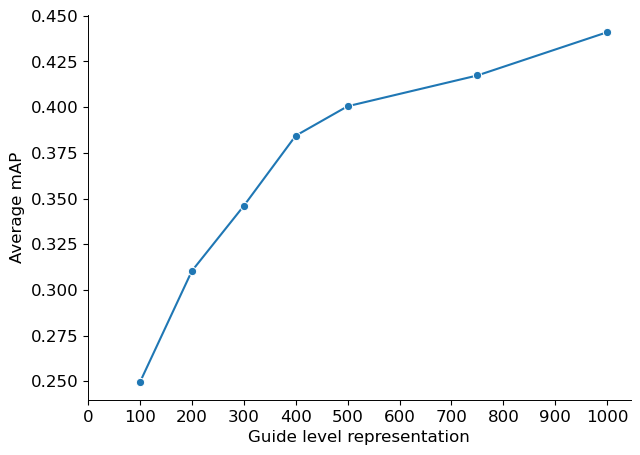

In [11]:
ys = []
for n in subsample_ns:
    y = [i[1] for i in rep_results[n] if i[1]]
    ys.append(np.mean(y))

mpl.rc('axes', linewidth=0.7)
mpl.rc('ytick', labelsize=12)
mpl.rc('xtick', labelsize=12)

fig, ax = plt.subplots(figsize=(7,5))

ax = sns.lineplot(x=subsample_ns, y=ys, errorbar=None, style=1, markers=True, legend=False)
ax.set_title('',size=14)
ax.set_xlabel('Guide level representation',size=12)
ax.set_ylabel('Average mAP',size=12)
ax.set_xticks(range(0,1001,100))

# draw reference lines for screen data
#plt.axvline(x=117, color = 'orange', linestyle='dashed', label='A549')
#plt.text(160,.58,'-- A549',color='orange')
#plt.axvline(x=125, color = 'red', linestyle='dashed', label='HeLa DMEM')
#plt.text(160,.56,'-- HeLa DMEM',color='red')
#plt.axvline(x=93, color = 'brown', linestyle='dashed', label='HeLa HPLM')
#plt.text(160,.6,'-- HeLa HPLM',color = 'brown')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(os.path.join(output_folder,'figure_panels','CP498_SABER_arm_1_2_subsample_average_mAP.png'),dpi = 300,bbox_inches='tight')
plt.show()